<a href="https://colab.research.google.com/github/valdolab/DS_mAIstros/blob/main/Week7/API_CV_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# API

## Forecasting periots of time series using data extraced in videos

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import pickle # to make dataframe copy

class TimeSeries():

    def __init__(self, data):
        #removed ds of the dataset for LSTM
        self.dataset = pickle.loads(pickle.dumps(data.drop(columns='ds')))
        # for ARIMA and others
        self.data_set = data.copy(deep=True)
        self.data_set['ts_log'] = self.data_set['ts'].apply(lambda x: np.log(x))
        decomposition = seasonal_decompose(self.data_set['ts_log'], period=48, extrapolate_trend=1)
        self.data_set.loc[:, 'trend'] = decomposition.trend
        self.data_set.loc[:, 'seasonal'] = decomposition.seasonal
        self.data_set.loc[:, 'residual'] = decomposition.resid


    def plot_decomposition(self):
        f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(15,5), sharex=True )

        ax1.plot(self.data_set['ts'], label="Original")
        ax1.legend(loc='best')
        ax1.tick_params(axis ='x', rotation=45)

        ax2.plot(self.data_set['trend'], label="Trend")
        ax2.legend(loc='best')
        ax2.tick_params(axis ='x', rotation=45)

        ax3.plot(self.data_set['seasonal'], label="Seasonal")
        ax3.legend(loc='best')
        ax3.tick_params(axis ='x', rotation=45)

        ax4.plot(self.data_set['residual'], label="Residuals")
        ax4.legend(loc='best')
        ax4.tick_params(axis ='x', rotation=45)

        plt.tight_layout()
        plt.savefig("static/graphs/decomposition.png")
        plt.show()

    # function to plot the stationarity, Rolling Mean = Moving average
    def test_stationarity(self):
        dftest = adfuller(self.data_set['residual'], autolag='AIC')
        df = self.data_set
        ts = 'ts'
        rolmean = df[ts].rolling(window=12, center= False).mean()
        rolstd =  df[ts].rolling(window=12, center = False).std()

        orig = plt.plot(df[ts], color = 'blue', label ="Original")
        mean = plt.plot(rolmean, color ='red', label ="Rolling Mean")
        std = plt.plot(rolstd, color='black', label ="Rolling Std")
        plt.legend(loc = 'best')
        plt.title("Rolling Mean and Standard Deviation for  %s" %(ts))
        plt.xticks(rotation =45)
        plt.show(block = False)
        plt.close

        print('Results:')
        dftest = adfuller(df[ts], autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=["Test Statistic",'p=value','# Lasgs Used',' Number of Observations'])

        for key, value in dftest[4].items():
            dfoutput['Critical Value(%s)' %key]= value

        print(dfoutput)

    def ACF_PACF(self):

        # Create figure
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

        # Plot the ACF of df
        plot_acf(self.data_set['residual'], lags=10, zero=False, ax=ax1)

        # Plot the PACF of df
        plot_pacf(self.data_set['residual'], lags=10, zero=False, ax=ax2)

    def run_Arima(self, p, d, q):
        df = self.data_set
        ts = 'ts'
        model = ARIMA(df[ts], order=(p,d,q))
        results_arima = model.fit()

        len_results = len(results_arima.fittedvalues)
        ts_modify = df[ts][-len_results:]
        # root sum of squares
        rss = sum((results_arima.fittedvalues - ts_modify)**2)
        # root mean sum error
        rmse = np.sqrt(rss/len(df[ts]))

        print('RMSE: ', rmse)

#         plt.figure()
#         plt.plot(df[ts])
#         plt.plot(results_arima.fittedvalues, color='red')
#         plt.show()

        return results_arima

    # convert an array of values into a dataset matrix
    def create_dataset(self, dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)

    def smape(a, f):
        return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f)))

    def LSTM_model(self):
        # fix random seed for reproducibility
        tf.random.set_seed(42)

        # normalize the dataset
        dataset = self.dataset
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        dataset = self.scaler.fit_transform(dataset)

        # split into train and test sets
        train_size = int(len(dataset) * 0.90)
        test_size = len(dataset) - train_size
        self.train, self.test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
        print(len(self.train), len(self.test))

        look_back = 1
        trainX, self.trainY = self.create_dataset(self.train, look_back)
        testX, self.testY = self.create_dataset(self.test, look_back)

        # reshape input to be [samples, time steps, features]
        self.trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        self.testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

        # create and fit the LSTM network
        self.model = Sequential()
        self.model.add(LSTM(4, input_shape=(1, look_back)))
        self.model.add(Dense(1))
        self.model.compile(loss='mean_squared_error', optimizer='adam')
        self.model.fit(self.trainX, self.trainY, epochs=50, batch_size=1, verbose=2)
        self.dataset = dataset
#         tf.keras.utils.plot_model(self.model)

    def forecast(self, model, X, n):

        if(n <= self.testX.shape[0]):
            #make the n prediction
            X_input = X[0:n]

        else:
            #make the recursive predictions to n
            X_input = X
            lasts_features = self.testX[self.testX.shape[0]-1:self.testX.shape[0]]
            look_forward = n - X.shape[0]
            for i in range(look_forward):
                one_pre = self.model.predict(lasts_features)
                one_pre = one_pre[0][0]
                #create new feature and concat
                olds = self.testX[-1][0][1:lasts_features.shape[2]]
                news = np.concatenate((olds, [one_pre]))
                X_input = np.concatenate((X_input, [[news]]))

        Predictions = self.model.predict(X_input)

        return Predictions, X_input

    def LSTM_predict(self, periods):
        look_back = 1
        # make predictions

        # make predictions training
        # make predictions training
        trainPredict = self.model.predict(self.trainX)
        #make forcasting
        #testPredict = model.predict(testX)
        testPredict, xinputs = self.forecast(self.model,self.testX,int(periods))

        # invert predictions, reverse normalization
        trainPredict_ = self.scaler.inverse_transform(trainPredict)
        trainY_ = self.scaler.inverse_transform([self.trainY])
        testPredict_ = self.scaler.inverse_transform(testPredict)
        testY_ = self.scaler.inverse_transform([self.testY])

        # shift train predictions for plotting
        trainPredictPlot = np.empty_like(self.dataset)
        trainPredictPlot[:, :] = np.nan
        trainPredictPlot[look_back:len(trainPredict_)+look_back, :] = trainPredict_
        # shift test predictions for plotting
        #testPredictPlot = np.empty_like(dataset)

        size_testP = testPredict_.shape[0]

        dis1 = len(trainPredict_)+(look_back*2)+1
        dis2 = (len(trainPredict_)+(look_back*2)+1)+size_testP

        testPredictPlot = np.empty((dis2,1,))
        testPredictPlot[:, :] = np.nan
        testPredictPlot[dis1:dis2,:] = testPredict_

        true_testPredict = np.empty_like(self.dataset)
        true_testPredict[:, :] = np.nan
        true_testPredict[len(trainPredict)+(look_back*2)+1:len(self.dataset)-1, :] = testY_.T

        # plot baseline and predictions
        plt.figure(figsize=(16,6))
#         plt.plot(self.scaler.inverse_transform(self.train))
        plt.plot(trainPredictPlot, label='Time Series')
        plt.plot(true_testPredict[:len(true_testPredict)//2,:], color='gray', label='True value')
        plt.plot(testPredictPlot, label='Prediction')
        plt.axvline(x=110, color='red')
        plt.axvline(x=216, color='red')
        plt.axvline(x=314, color='red')
        plt.axvline(x=420, color='red')
        plt.xlabel("Timeline")
        plt.ylabel("People")
        plt.legend()
        plt.savefig("static/graphs/LSTM-prediction.png")
        plt.show()

In [ ]:
# ARIMA and LSTM

In [ ]:
data_set = pd.read_csv("time_series_4days_sum.csv")
# data_set['ts'] = data_set['ts'] / 150
# data_set['ts'] = [1 if val > 0.2 and val < 1 else int(val) for val in data_set['ts']]
# data_set['ts'][data_set["ts"] == 0] = 0.000001
data_set['ds'] = data_set['Unnamed: 0']
data_set = data_set.drop(columns='Unnamed: 0')
print(data_set.columns)

timeMethods = TimeSeries(data_set)
# timeMethods.test_stationarity()
timeMethods.LSTM_model()
# result = timeMethods.run_Arima(0,0,0)
# timeMethods.plot_decomposition()

# my_forecast = result.forecast(230)
# plt.figure()
# plt.plot(timeMethods.data_set['ts'])
# plt.plot(my_forecast, color='green')
# plt.savefig("static/graphs/prediction.png")

Index(['ds', 'ts'], dtype='object')
378 42
Epoch 1/50
376/376 - 2s - loss: 0.0174 - 2s/epoch - 4ms/step
Epoch 2/50
376/376 - 0s - loss: 0.0161 - 394ms/epoch - 1ms/step
Epoch 3/50
376/376 - 0s - loss: 0.0155 - 409ms/epoch - 1ms/step
Epoch 4/50
376/376 - 0s - loss: 0.0150 - 377ms/epoch - 1ms/step
Epoch 5/50
376/376 - 0s - loss: 0.0147 - 395ms/epoch - 1ms/step
Epoch 6/50
376/376 - 0s - loss: 0.0144 - 408ms/epoch - 1ms/step
Epoch 7/50
376/376 - 0s - loss: 0.0143 - 403ms/epoch - 1ms/step
Epoch 8/50
376/376 - 0s - loss: 0.0142 - 377ms/epoch - 1ms/step
Epoch 9/50
376/376 - 0s - loss: 0.0142 - 407ms/epoch - 1ms/step
Epoch 10/50
376/376 - 0s - loss: 0.0142 - 414ms/epoch - 1ms/step
Epoch 11/50
376/376 - 0s - loss: 0.0141 - 409ms/epoch - 1ms/step
Epoch 12/50
376/376 - 0s - loss: 0.0141 - 460ms/epoch - 1ms/step
Epoch 13/50
376/376 - 0s - loss: 0.0140 - 436ms/epoch - 1ms/step
Epoch 14/50
376/376 - 0s - loss: 0.0141 - 461ms/epoch - 1ms/step
Epoch 15/50
376/376 - 1s - loss: 0.0140 - 513ms/epoch - 1ms

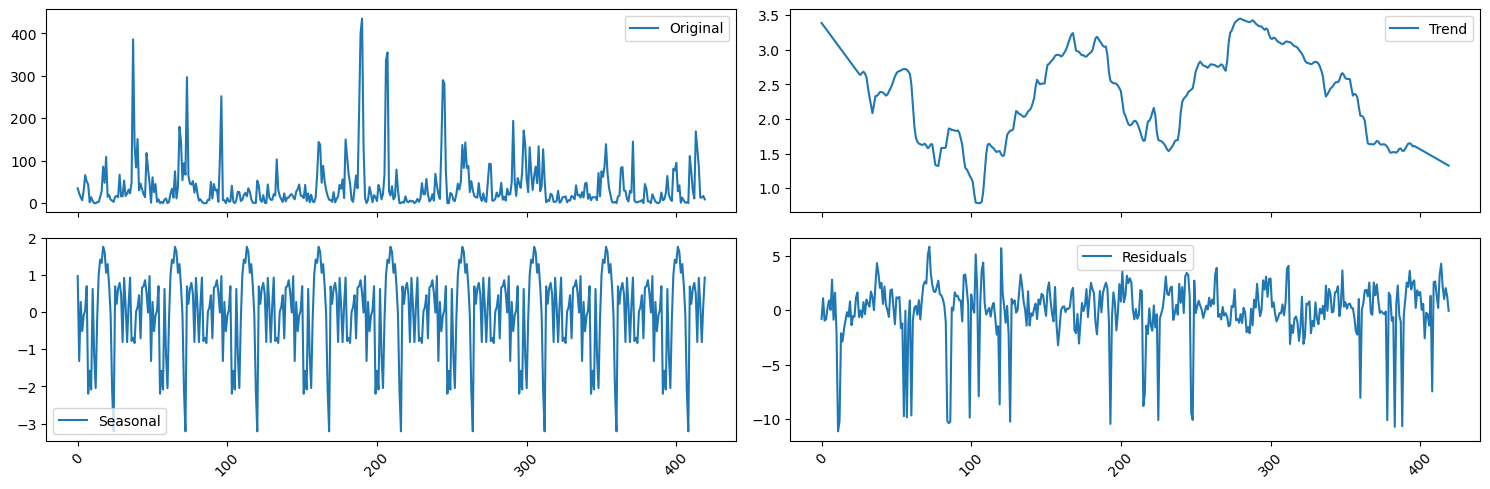

2/2 [==============================] - 0s 3ms/step


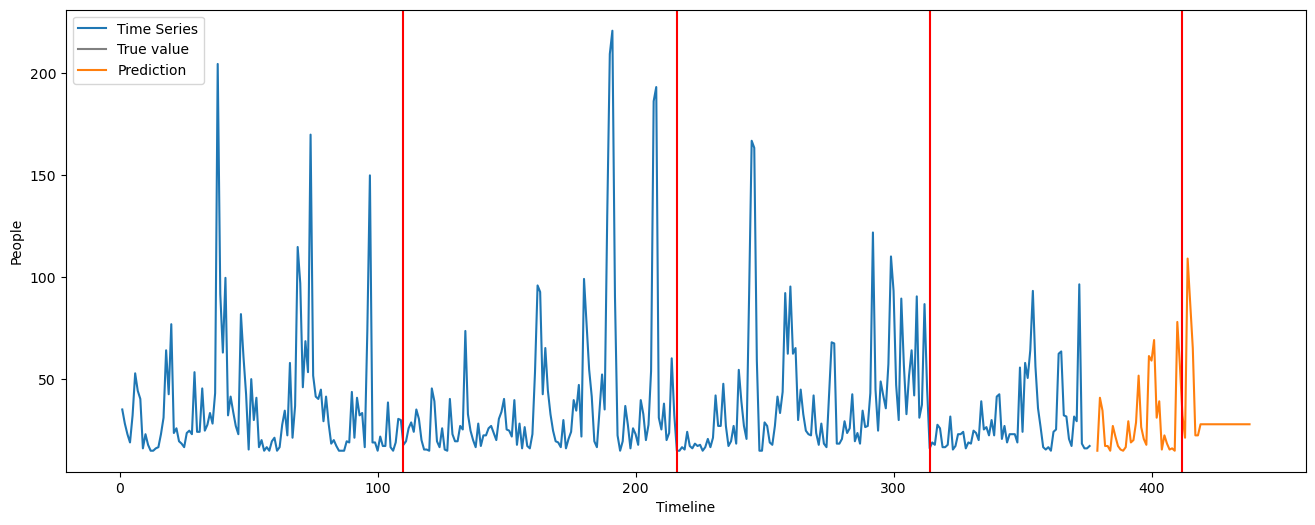

In [ ]:
timeMethods.plot_decomposition()
timeMethods.LSTM_predict(60)

## Endpoint

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses.
 * Running on http://172.168.23.193:2001/ (Press CTRL+C to quit)
172.168.23.193 - - [17/Apr/2023 08:34:17] "GET / HTTP/1.1" 200 -
172.168.23.193 - - [17/Apr/2023 08:34:17] "GET /static/cobra-logo.jpeg HTTP/1.1" 200 -
172.168.23.193 - - [17/Apr/2023 08:34:17] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 18ms/step


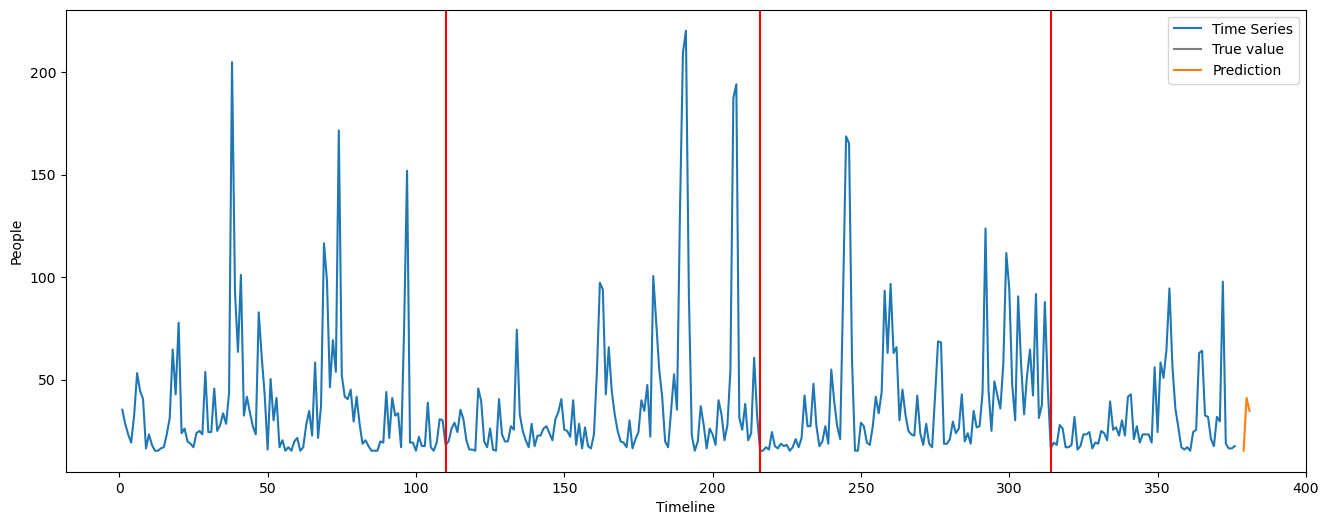

172.168.23.193 - - [17/Apr/2023 08:34:20] "POST /predict HTTP/1.1" 200 -
172.168.23.193 - - [17/Apr/2023 08:34:20] "GET /static/graphs/LSTM-prediction.png HTTP/1.1" 200 -
172.168.23.193 - - [17/Apr/2023 08:34:20] "GET /static/graphs/decomposition.png HTTP/1.1" 200 -


In [ ]:
from flask import Flask, request, render_template,jsonify, send_file
from PIL import Image
import os
# Create a Flask app instance with the name of the current module
app = Flask(__name__)

@app.route('/')
def home():
    app.config['UPLOAD_FOLDER'] = os.path.join('static', 'graphs')
    return render_template('index-0.html') #, **locals())

@app.route('/predict',methods=['POST','GET'])
def predict():

    input_text = str(request.form['days_input'])

    timeMethods.LSTM_predict(int(input_text))
#     result = timeMethods.run_Arima(1,0,0)

#     my_forecast = result.forecast(int(input_text))
#     plt.figure()
#     plt.plot(timeMethods.data_set['ts'])
#     plt.plot(my_forecast, color='green')
#     plt.savefig("static/graphs/prediction.png")
    full_images = []
    full_images.append(os.path.join(app.config['UPLOAD_FOLDER'], 'LSTM-prediction.png'))

    full_images.append(os.path.join(app.config['UPLOAD_FOLDER'], 'decomposition.png'))

    #output = round(prediction[0], 2)
    return render_template('index-0.html', results = full_images)

@app.after_request
def add_header(response):
    response.cache_control.max_age = 5
    return response

if __name__ == '__main__':
    app.run( host='0.0.0.0', port=2001)